In [85]:
import torch
from torch import nn
import matplotlib.pyplot as plt
# import datasets and helper function
from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split


In [86]:
NUM_CLASSES = 4 # no of output classes
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5, # standard deviationA
    random_state= RANDOM_SEED
)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) # Because of CE needs long targets
X_blob[:5],y_blob[:5]

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 tensor([3, 2, 2, 1, 1]))

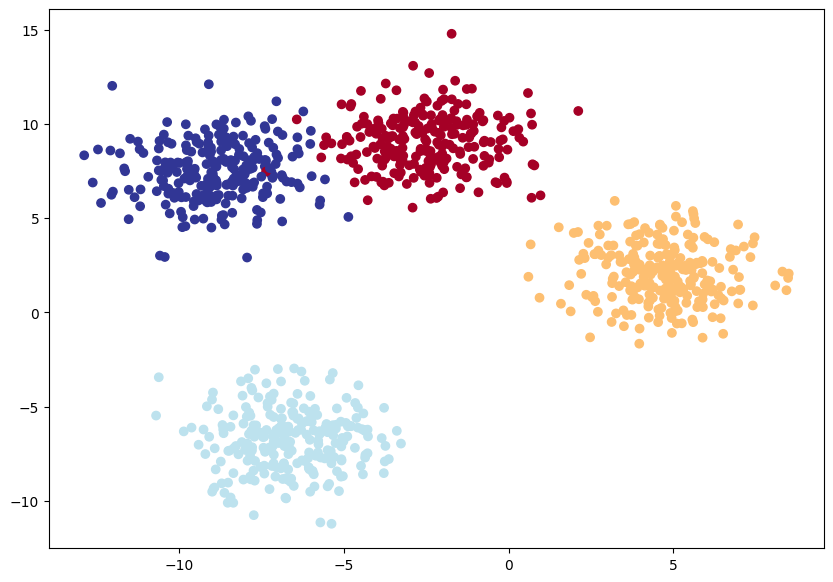

In [87]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_blob
                                                    ,y_blob,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)


In [89]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [90]:
class BlobModel(nn.Module):
    def __init__(self, input_count, output_count, hidden_units = 8):
        super().__init__()
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=input_count, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_count),
        )
        
    def forward(self, x):
        return self.linear_layers(x)

model = BlobModel(input_count=NUM_FEATURES,
                  output_count=NUM_CLASSES).to(device)

model

BlobModel(
  (linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [91]:
loss_fn = nn.CrossEntropyLoss() # Not Binary Cross Entroby as we are in
                                # Binary Classification
                                
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [92]:
#Lets do one pass over the model to check output

y_logits = model(X_test.to(device))
y_preds = torch.softmax(y_logits, dim=1)# Now instead of sigmoid we use softmax
                                        # To make the sum of the preds = 1
                                        # (Probabilty) <(￣︶￣)>

y_logits[:3], y_preds[:3], y_preds[0].sum()


(tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
         [ 1.7168, -1.2270,  1.7367,  2.1010],
         [ 2.2400,  0.7714,  2.6020,  1.0107]], device='cuda:0',
        grad_fn=<SliceBackward0>),
 tensor([[0.1872, 0.2918, 0.1495, 0.3715],
         [0.2824, 0.0149, 0.2881, 0.4147],
         [0.3380, 0.0778, 0.4854, 0.0989]], device='cuda:0',
        grad_fn=<SliceBackward0>),
 tensor(1., device='cuda:0', grad_fn=<SumBackward0>))

In [93]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()

    y_logits = model(X_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_preds)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    # Test
    model.eval()
    
    with torch.inference_mode():
        
        test_logits = model(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)
        
        # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.96335, Test Acc: 71.00%
Epoch: 10 | Loss: 0.63688, Acc: 79.50% | Test Loss: 0.61222, Test Acc: 88.00%
Epoch: 20 | Loss: 0.46945, Acc: 97.75% | Test Loss: 0.45865, Test Acc: 98.00%
Epoch: 30 | Loss: 0.37339, Acc: 98.50% | Test Loss: 0.36771, Test Acc: 99.00%
Epoch: 40 | Loss: 0.31009, Acc: 98.62% | Test Loss: 0.30659, Test Acc: 99.00%
Epoch: 50 | Loss: 0.26486, Acc: 98.88% | Test Loss: 0.26227, Test Acc: 99.00%
Epoch: 60 | Loss: 0.23082, Acc: 98.88% | Test Loss: 0.22853, Test Acc: 99.50%
Epoch: 70 | Loss: 0.20429, Acc: 99.12% | Test Loss: 0.20197, Test Acc: 99.50%
Epoch: 80 | Loss: 0.18307, Acc: 99.12% | Test Loss: 0.18057, Test Acc: 99.00%
Epoch: 90 | Loss: 0.16578, Acc: 99.12% | Test Loss: 0.16301, Test Acc: 99.00%


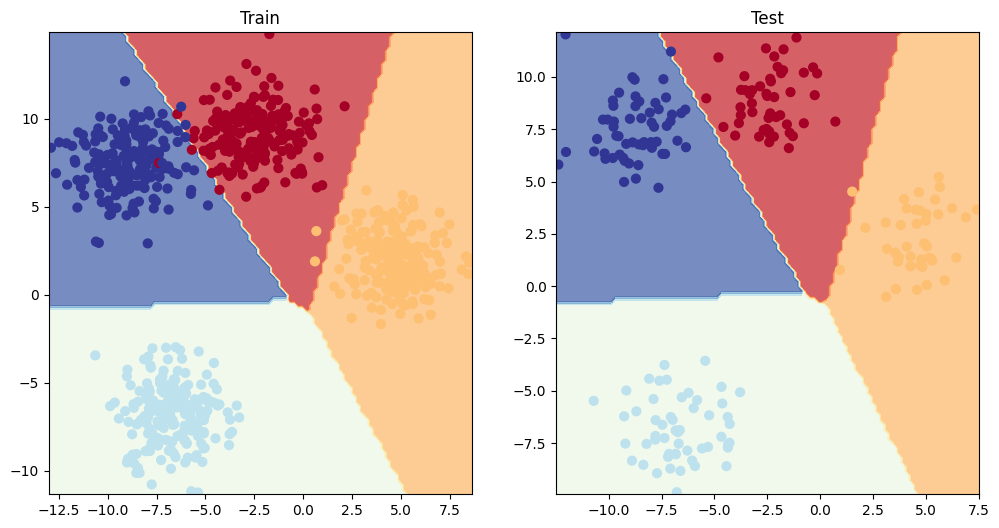

In [94]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)